In [1]:
#---------------------------------------------------------------------------------------------GENERAL-----------------------------------------------------------------------------------------------
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import VOCDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.multiprocessing as mp
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from typing import Dict
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image
import xml.etree.ElementTree as ET
import collections
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn as nn
import torchviz
from torchsummary import summary
import pytesseract
import re
import cv2  
import easyocr
import keras_ocr


# Specify Tesseract path (example for Windows)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

#-------------------------------------------------------------------------------------JUPYTER NOTEBOOK SETTINGS-------------------------------------------------------------------------------------
from IPython.core.display import display, HTML                                    
display(HTML("<style>.container { width:100% !important; }</style>"))     

C:\Users\Ciprian-Florin Ifrim\AppData\Local\Temp\ipykernel_17188\2786350239.py:47: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Load the pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Replace the classifier with a new one
num_classes = 6
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Put model to device
device = torch.device('cpu')
model.to(device)

# Load saved model
model.load_state_dict(torch.load('pytorch_rcnn_models/FINAL-v2_rcnn_batch-16_epoch-40_full-enchanced-original_non-augmented.pt'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
# Data processing
data_transforms = transforms.Compose([
    transforms.Resize(512),                                            
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
image_path = 'pascal_voc_datasets/VOCdevkit/PlotsEnchanced_Original_NoAugmentation/JPEGImages/'
img_name = 'image1'
CUSTOM_CLASSES = {"name": 1, "value": 2, "x-axis": 3, "y-axis": 4, "plot":5}

img = Image.open(image_path + img_name + '.jpg')
orig_width, orig_height = img.size                                   # Store the original image dimensions

# Process the image
img_processed = data_transforms(img)

# Calculate the scale ratios
new_width, new_height = img_processed.shape[1], img_processed.shape[2]

# Calculate the scale ratios
if orig_width <= orig_height:
    new_height = 512
    new_width = int(orig_width * (new_height / orig_height))
else:
    new_width = 512
    new_height = int(orig_height * (new_width / orig_width))
    
width_ratio = new_width / orig_width
height_ratio = new_height / orig_height

with torch.no_grad():
    prediction = model([img_processed])

# Scale bounding boxes back to original image size
for box in prediction[0]['boxes']:
    box[0] *= (1 / width_ratio)
    box[2] *= (1 / width_ratio)
    box[1] *= (1 / height_ratio)
    box[3] *= (1 / height_ratio)

# Debugging
#print(prediction[0]['boxes'])
print(prediction[0]['scores'])


results = {}                                 # Dictionary to store the results
label5_image = None                          # Variable to store the cropped image for label 5

for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if label >= 1 and label <= 4 and score > 0.7:                                                 # Check if the score is above 0.7 and label is between 1 and 4
        xmin, ymin, xmax, ymax = [int(i) for i in box]                                            # Convert box coordinates to integers
        cropped_image = img.crop((xmin, ymin, xmax, ymax))                                        # Crop the image
        bw_img = cropped_image.convert("L")                                                       # Convert the cropped image to grayscale (black and white)
        bw_img_array = np.array(bw_img)

        # Resize the image (e.g., double the size)
        resized_img = cv2.resize(bw_img_array, (0,0), fx=2, fy=2, interpolation = cv2.INTER_CUBIC)

        # Contrast Enhancement
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(32, 32))
        enhanced_img = clahe.apply(resized_img)

        # Apply Otsu's thresholding
        _, thresh_img = cv2.threshold(enhanced_img, 200, 30, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Assuming resized_img has been defined as in your snippet
        plt.figure(figsize=(10, 10))
        plt.imshow(thresh_img, cmap='gray')
        plt.title('Image')
        plt.axis('off')  # To turn off the axis
        plt.show()


        
        # Determine the whitelist of characters based on the label
        if label == CUSTOM_CLASSES['y-axis']:
            config = r"--oem 1 --psm 3 -c tessedit_char_whitelist=0123456789.e-"
        else:
            config = '--oem 1'
            
        text = pytesseract.image_to_string(thresh_img, config=config)                              # Now you can process the cropped image with Pytesseract
        text = re.sub('\n+', ',', text)                                                           # Replace one or more consecutive newline characters with a single comma
        label_name = [name for name, id in CUSTOM_CLASSES.items() if id == label][0]              # Find the label name using the CUSTOM_CLASSES dictionary
        results[label_name] = text                                                                # Store the result in the dictionary
        
    elif label == 5 and score > 0.8:                                                              # Check if the label is 5 and the score is above 0.7
        xmin, ymin, xmax, ymax = [int(i) for i in box]                                            # Convert box coordinates to integers
        label5_image = img.crop((xmin, ymin, xmax, ymax))                                         # Crop the image for label 5

# The results dictionary now contains the extracted text for labels 1 to 4
print(results)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


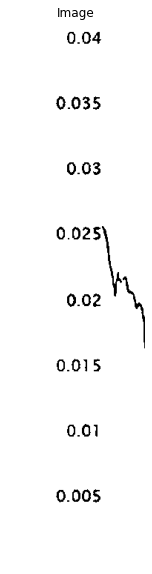

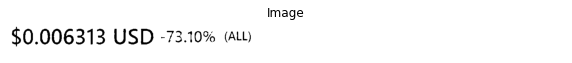

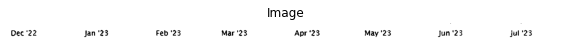

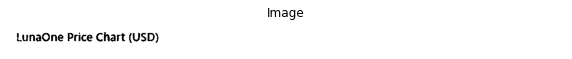

{'y-axis': '0.04,0.035,0.03,0.025,0.02,0.015,0.01,0.005', 'value': '$0.006313 USD -73.10%,(ALL)', 'x-axis': "Dec '22,Jan '23,Feb '23,Mar '23,Apr '23,'23,Jun '23,Jul '23,May", 'name': 'LunaOne Price Chart (USD)'}


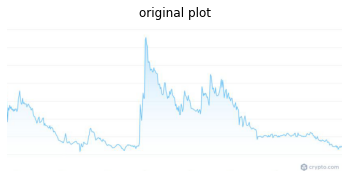

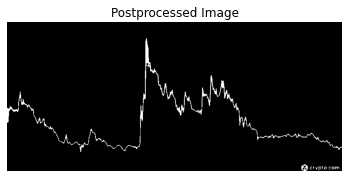

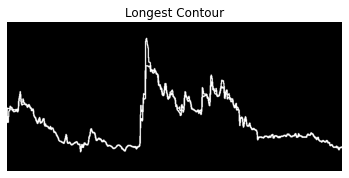

Lowest Pixel (y axis): (182, 321)
Highest Pixel (y axis): (346, 40)
Right-Most Pixel (highest x coordinate): (832, 310)


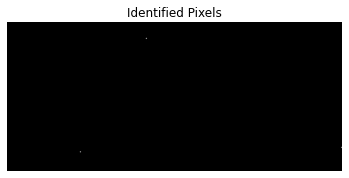

In [92]:
image_path = 'pascal_voc_datasets/VOCdevkit/PlotsEnchanced_Original_NoAugmentation/JPEGImages/'
img_name = 'image121387'
CUSTOM_CLASSES = {"name": 1, "value": 2, "x-axis": 3, "y-axis": 4, "plot":5}

img = Image.open(image_path + img_name + '.jpg')
orig_width, orig_height = img.size                                   # Store the original image dimensions

# Process the image
img_processed = data_transforms(img)

# Calculate the scale ratios
new_width, new_height = img_processed.shape[1], img_processed.shape[2]

# Calculate the scale ratios
if orig_width <= orig_height:
    new_height = 512
    new_width = int(orig_width * (new_height / orig_height))
else:
    new_width = 512
    new_height = int(orig_height * (new_width / orig_width))
    
width_ratio = new_width / orig_width
height_ratio = new_height / orig_height

with torch.no_grad():
    prediction = model([img_processed])

# Scale bounding boxes back to original image size
for box in prediction[0]['boxes']:
    box[0] *= (1 / width_ratio)
    box[2] *= (1 / width_ratio)
    box[1] *= (1 / height_ratio)
    box[3] *= (1 / height_ratio)

# Debugging
#print(prediction[0]['boxes'])
print(prediction[0]['scores'])


results = {}                                 # Dictionary to store the results
label5_image = None                          # Variable to store the cropped image for label 5

reader = easyocr.Reader(lang_list=['en'])       # Create a reader to recognize the English language

for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if label >= 1 and label <= 4 and score > 0.7:                                                 # Check if the score is above 0.7 and label is between 1 and 4
        xmin, ymin, xmax, ymax = [int(i) for i in box]                                            # Convert box coordinates to integers
        cropped_image = img.crop((xmin, ymin, xmax, ymax))                                        # Crop the image
        bw_img = cropped_image.convert("L")                                                       # Convert the cropped image to grayscale (black and white)
        bw_img_array = np.array(bw_img)

        # Resize the image (e.g., double the size)
        resized_img = cv2.resize(bw_img_array, (0,0), fx=2, fy=2, interpolation = cv2.INTER_CUBIC)

        # Contrast Enhancement
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(32, 32))
        enhanced_img = clahe.apply(resized_img)

        # Apply Otsu's thresholding
        _, thresh_img = cv2.threshold(enhanced_img, 20, 50, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Assuming resized_img has been defined as in your snippet
        plt.figure(figsize=(10, 10))
        plt.imshow(thresh_img, cmap='gray')
        plt.title('Image')
        plt.axis('off')  # To turn off the axis
        plt.show()

        result = reader.readtext(thresh_img, detail = 0)
        text = ','.join(result)
        text = re.sub('\n+', ',', text)                                                           # Replace one or more consecutive newline characters with a single comma
        label_name = [name for name, id in CUSTOM_CLASSES.items() if id == label][0]              # Find the label name using the CUSTOM_CLASSES dictionary
        results[label_name] = text                                                                # Store the result in the dictionary
        
    elif label == 5 and score > 0.8:                                                              # Check if the label is 5 and the score is above 0.7
        xmin, ymin, xmax, ymax = [int(i) for i in box]                                            # Convert box coordinates to integers
        label5_image = img.crop((xmin, ymin, xmax, ymax))                                         # Crop the image for label 5

# The results dictionary now contains the extracted text for labels 1 to 4
print(results)

#############################################################################################################################
plt.imshow(label5_image)
plt.title("original plot")
plt.axis('off')
plt.show()
    
# Plot processing
bw_label5_img = label5_image.convert("L")                                                       # Convert the cropped image to grayscale (black and white)
bw_label5_img_array = np.array(bw_label5_img)

# Apply Gaussian blur to reduce noise and improve the result of Canny edge detection
blurred_label5_img = cv2.GaussianBlur(bw_label5_img_array, (3, 3), 0)

# First, apply a binary threshold on the image
_, thresh_label5_img = cv2.threshold(blurred_label5_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

inverted_label5_img = cv2.bitwise_not(thresh_label5_img)

# Define a kernel for the erosion (a 3x3 square is common)
kernel = np.ones((2,2), np.uint8)
eroded_label5_img = cv2.erode(inverted_label5_img, kernel, iterations = 1)                  # Apply the erosion
closed_label5_img = cv2.morphologyEx(eroded_label5_img, cv2.MORPH_CLOSE, kernel)

plt.imshow(closed_label5_img, cmap='gray')
plt.title('Postprocessed Image')
plt.axis('off')
plt.show()

######################################################################################################################
# Find the contours
contours, hierarchy = cv2.findContours(closed_label5_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the perimeter for each contour and find the index of the longest one
max_length = 0
longest_contour_index = 0
for i, contour in enumerate(contours):
    length = cv2.arcLength(contour, True) # The 'True' argument indicates that the contour is closed
    if length > max_length:
        max_length = length
        longest_contour_index = i
        
# Extract the longest contour
longest_contour = contours[longest_contour_index]

# Create a blank image to draw the longest contour
output_image = np.zeros_like(closed_label5_img)

# Draw the longest contour on the output image
cv2.drawContours(output_image, [longest_contour], -1, (255, 255, 255), 2)

# Show the image with the drawn contour using Matplotlib
plt.imshow(output_image, cmap='gray')
plt.title('Longest Contour')
plt.axis('off')
plt.show()


######################################################################################################################
# Find the lowest, highest, and right-most pixels
lowest_pixel = tuple(longest_contour[longest_contour[:, :, 1].argmax()][0])
highest_pixel = tuple(longest_contour[longest_contour[:, :, 1].argmin()][0])
right_most_pixel = tuple(longest_contour[longest_contour[:, :, 0].argmax()][0])

# Print the coordinates
print("Lowest Pixel (y axis):", lowest_pixel)
print("Highest Pixel (y axis):", highest_pixel)
print("Right-Most Pixel (highest x coordinate):", right_most_pixel)

# Create a blank image to draw the identified pixels
pixel_image = np.zeros_like(closed_label5_img)

# Draw the identified pixels on the blank image using a white color (255)
cv2.circle(pixel_image, lowest_pixel, radius=1, color=255, thickness=-1)
cv2.circle(pixel_image, highest_pixel, radius=1, color=255, thickness=-1)
cv2.circle(pixel_image, right_most_pixel, radius=1, color=255, thickness=-1)

# Show the image with the drawn pixels using Matplotlib
plt.imshow(pixel_image, cmap='gray')
plt.title('Identified Pixels')
plt.axis('off')
plt.show()

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Looking for C:\Users\Ciprian-Florin Ifrim\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Ciprian-Florin Ifrim\.keras-ocr\crnn_kurapan.h5


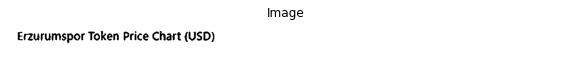

1/1 [==============================] - 1s 920ms/step


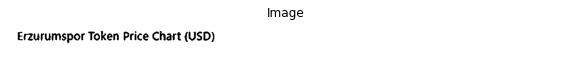

1/1 [==============================] - 0s 88ms/step


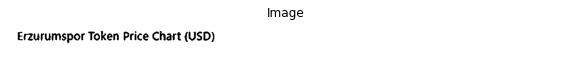

1/1 [==============================] - 0s 244ms/step


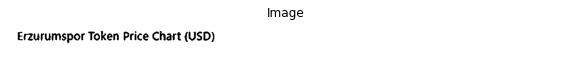

1/1 [==============================] - 0s 102ms/step
{'y-axis': 'ts,125,o75,o,5,o,25', 'value': 's01217,usd,t2481700,all', 'x-axis': '22,sep,2z,nov,2z,25,mar,22,may,22,jul,jan,25,mar,z5,may,jul,25', 'name': 'erzurumspor,token,price,chart,usdy'}


In [9]:
image_path = 'pascal_voc_datasets/VOCdevkit/PlotsEnchanced_Original_NoAugmentation/JPEGImages/'
img_name = 'image117687'
CUSTOM_CLASSES = {"name": 1, "value": 2, "x-axis": 3, "y-axis": 4, "plot":5}

img = Image.open(image_path + img_name + '.jpg')
orig_width, orig_height = img.size                                   # Store the original image dimensions

# Process the image
img_processed = data_transforms(img)

# Calculate the scale ratios
new_width, new_height = img_processed.shape[1], img_processed.shape[2]

# Calculate the scale ratios
if orig_width <= orig_height:
    new_height = 512
    new_width = int(orig_width * (new_height / orig_height))
else:
    new_width = 512
    new_height = int(orig_height * (new_width / orig_width))
    
width_ratio = new_width / orig_width
height_ratio = new_height / orig_height

with torch.no_grad():
    prediction = model([img_processed])

# Scale bounding boxes back to original image size
for box in prediction[0]['boxes']:
    box[0] *= (1 / width_ratio)
    box[2] *= (1 / width_ratio)
    box[1] *= (1 / height_ratio)
    box[3] *= (1 / height_ratio)

# Debugging
#print(prediction[0]['boxes'])
print(prediction[0]['scores'])


# Create a recognition pipeline
pipeline = keras_ocr.pipeline.Pipeline()

results = {}                                 # Dictionary to store the results
label5_image = None                          # Variable to store the cropped image for label 5

for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if label >= 1 and label <= 4 and score > 0.7:
        xmin, ymin, xmax, ymax = [int(i) for i in box]
        cropped_image = img.crop((xmin, ymin, xmax, ymax))
        cropped_image_array = np.array(cropped_image)

        plt.figure(figsize=(10, 10))
        plt.imshow(thresh_img, cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.show()

        result = pipeline.recognize([cropped_image_array])[0]
        text = ','.join([word[0] for word in result])
        text = re.sub('\n+', ',', text)
        label_name = [name for name, id in CUSTOM_CLASSES.items() if id == label][0]
        results[label_name] = text
        
    elif label == 5 and score > 0.8:
        xmin, ymin, xmax, ymax = [int(i) for i in box]
        label5_image = img.crop((xmin, ymin, xmax, ymax))

print(results)

In [ ]:
# Draw the bounding boxes on the image
fig, ax = plt.subplots(1, figsize=(17, 15))  # Adjust the size as needed. Here, the figure size is 12x12 inches.
ax.imshow(img)

colors = ['r', 'g', 'b', 'y', 'm']

# We will draw all the boxes with a score above 0.7
for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if score > 0.7:  # Check if the score is above 0.9
        xmin, ymin, xmax, ymax = box.numpy()  # Move the box coordinates to the CPU
        rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), edgecolor=colors[label%4], facecolor='none')
        ax.add_patch(rect)

plt.show()